# Process results
This notebook processes the results presented in the paper in figures 1-4. These compare the C-MOKG acquisition function with alternatives HVKG and JES-LB, and show the convergence of both forms of regret to zero. They also show an example of convergence of the predicted Pareto front.

In [26]:
def ensure_root_dir_on_path():
    import os
    import sys

    sources_root_path = os.path.abspath("../src")
    if sources_root_path not in sys.path:
        sys.path.append(sources_root_path)


ensure_root_dir_on_path()

In [27]:
import os

import pandas as pd
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from tqdm.notebook import tqdm

from decoupledbo.postprocessing import (
    DataLoader,
    interpolate_metrics,
    calculate_regret,
    calculate_stats,
    calculate_timing_stats,
    plot_mean_metrics_comparison,
    plot_pareto_fronts_for_several_iterations,
    plot_pareto_front,
    plot_acqf_optim_timing_medians,
)

In [28]:
torch.set_default_dtype(torch.double)

In [29]:
SAVE_PLOTS = True  # If set to true, save plots when the notebook is run
PLOTS_DIR = "./plots/"

if SAVE_PLOTS and not os.path.exists(PLOTS_DIR):
    os.mkdir(PLOTS_DIR)

## Load data

In [30]:
ROOT_DATA_DIR = os.path.abspath(f"../data-cluster/")

# Seven combinations of (test problem family, algorithm) were run to produce the results of the three experiments in the paper.
DIR_NAMES = {
    ("lengthscales", "kg-discrete"): "lengthscales-expectation-refitalways-2023-05-26",
    ("lengthscales", "kg-discrete-random"): "lengthscales-random-refitalways-2023-05-26",
    ("lengthscales", "jes"): "lengthscales-jes-refitalways-2023-05-22",
    ("lengthscales", "hvkg"): "lengthscales-hvkg-refitalways-2023-11-28",
    ("observationnoise", "kg-discrete"): "observationnoise-expectation-refitalways-2024-03-08",
    ("observationnoise", "jes"): "observationnoise-jes-refitalways-2024-03-08",
    ("observationnoise", "hvkg"): "observationnoise-hvkg-refitalways-2024-03-08",
}

DATA_DIRS = {k: os.path.join(ROOT_DATA_DIR, v) for k, v in DIR_NAMES.items()}


ROOT_PROBLEM_DIR = os.path.abspath(f"../data/shared/gp-problem/")
PROBLEM_DIRS = {k: os.path.join(ROOT_PROBLEM_DIR, k) for k in ["lengthscales", "observationnoise"]}

data_loader = DataLoader(DATA_DIRS, PROBLEM_DIRS)

In [31]:
# Note that, as shown by the warnings, a small number of runs failed for JES and HVKG
# and are excluded from the resulting metric plots.

all_metrics = {
    k: data_loader.load_and_concat_all_metrics(k)
    for k in tqdm(DATA_DIRS, desc="Loading data")
}

missing = {k: v2 for k, (v1, v2) in all_metrics.items()}
all_metrics = {k: v1 for k, (v1, v2) in all_metrics.items()}

Loading data:   0%|          | 0/7 [00:00<?, ?it/s]

Loading ('lengthscales', 'kg-discrete'):   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('lengthscales', 'kg-discrete-random'):   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('lengthscales', 'jes'):   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 17
Could not load run 49
Could not load run 51
Could not load run 54
Could not load run 72
Could not load run 75
Failed to load 6 out of 100 runs in total


Loading ('lengthscales', 'hvkg'):   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('observationnoise', 'kg-discrete'):   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('observationnoise', 'jes'):   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 2
Could not load run 17
Could not load run 35
Could not load run 40
Could not load run 84
Failed to load 5 out of 100 runs in total


Loading ('observationnoise', 'hvkg'):   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 5
Could not load run 7
Could not load run 11
Could not load run 38
Could not load run 39
Could not load run 77
Could not load run 96
Failed to load 7 out of 100 runs in total


In [32]:
# The max possible value is independent of the BO algorithm (the same family of test
# problems is used for each algorithm)
max_possible_scalar_perfs = {
    k1: data_loader.load_max_possible_scalar_perfs(k1, "kg-discrete")
    for k1 in ["lengthscales", "observationnoise"]
}
max_possible_hypervolumes = {
    k1: data_loader.load_max_possible_hypervolume(k1)
    for k1 in ["lengthscales", "observationnoise"]
}

## Process metrics
Before plotting the results, we need to interpolate metrics to all possible values of cumulative cost, then compute regret and average over all runs.

### Interpolate
The different runs will choose the objectives in different orders, so costs will not be aligned. Therefore, we will need to interpolate.

In [33]:
interp = {
    k1: {k2: interpolate_metrics(df_k) for k2, df_k in metrics_set.items()}
    for k1, metrics_set in tqdm(all_metrics.items(), desc="Interpolating metrics")
}

Interpolating metrics:   0%|          | 0/7 [00:00<?, ?it/s]

### Convert to regret
Since different problems have different maximum possible expected scalarised performances, we cannot simply average the expected scalarised performance. Instead, we subtract the expected scalarised performance from the maximum possible for that problem then average these to get a Bayes regret.

In [34]:
regret = {
    (problem_key, alg): {
        k2: calculate_regret(
            df_k,
            max_possible_scalar_perfs[problem_key],
            max_possible_hypervolumes[problem_key],
        )
        for k2, df_k in v1.items()
    }
    for (problem_key, alg), v1 in interp.items()
}

### Calculate statistics
Finally we calculate statistics such as:
  - mean and standard error in the mean
  - median and a 90% confidence interval (5% & 95% quantiles)

In [35]:
stats = {
    problem_key: pd.concat(
        {
            (alg, eval_mode): calculate_stats(regret_df)
            for k, alg in regret
            if k == problem_key
            for eval_mode, regret_df in regret[problem_key, alg].items()
        },
        axis="index",
        names=["algorithm", "eval_mode"],
    )
    for problem_key in sorted({k for k, alg in regret})
}

In [36]:
# Example of a stats dataframe
stats["lengthscales"]

hv_regret                                \
                                    mean       sem    median      cilo   
algorithm   eval_mode cost_cum                                           
kg-discrete decoupled 0              NaN       NaN       NaN       NaN   
                      1              NaN       NaN       NaN       NaN   
                      2              NaN       NaN       NaN       NaN   
                      3              NaN       NaN       NaN       NaN   
                      4              NaN       NaN       NaN       NaN   
...                                  ...       ...       ...       ...   
hvkg        fulleval  304       0.244197  0.045387  0.068866  0.000122   
                      305       0.244197  0.045387  0.068866  0.000122   
                      306       0.244197  0.045387  0.068866  0.000122   
                      307       0.244197  0.045387  0.068866  0.000122   
                      308       0.240287  0.045287  0.067768  0.000042   

                                                                         \
                                    cihi mean_minus_2sem mean_plus_2sem   
algorithm   eval_mode cost_cum                                            
kg-discrete decoupled 0              NaN             NaN            NaN   
                      1              NaN             NaN            NaN   
                      2              NaN             NaN            NaN   
                      3              NaN             NaN            NaN   
                      4              NaN             NaN            NaN   
...                                  ...             ...            ...   
hvkg        fulleval  304       1.226163        0.153423       0.334970   
                      305       1.226163        0.153423       0.334970   
                      306       1.226163        0.153423       0.334970   
                      307       1.226163        0.153423       0.334970   
                      308       1.225730        0.149713       0.330861   

                               scalarperf_regret                      \
                                            mean       sem    median   
algorithm   eval_mode cost_cum                                         
kg-discrete decoupled 0                      NaN       NaN       NaN   
                      1                      NaN       NaN       NaN   
                      2                      NaN       NaN       NaN   
                      3                      NaN       NaN       NaN   
                      4                      NaN       NaN       NaN   
...                                          ...       ...       ...   
hvkg        fulleval  304               0.067788  0.012017  0.022386   
                      305               0.067788  0.012017  0.022386   
                      306               0.067788  0.012017  0.022386   
                      307               0.067788  0.012017  0.022386   
                      308               0.063391  0.011344  0.024544   

                                                                    \
                                    cilo      cihi mean_minus_2sem   
algorithm   eval_mode cost_cum                                       
kg-discrete decoupled 0              NaN       NaN             NaN   
                      1              NaN       NaN             NaN   
                      2              NaN       NaN             NaN   
                      3              NaN       NaN             NaN   
                      4              NaN       NaN             NaN   
...                                  ...       ...             ...   
hvkg        fulleval  304       0.000574  0.241787        0.043755   
                      305       0.000574  0.241787        0.043755   
                      306       0.000574  0.241787        0.043755   
                      307       0.000574  0.241787        0.043755   
                      30

## Plot mean regret for the different experiments
These plots appear as Figures 1, 2 and 4 in the paper.

In [37]:
MAIN_ALGOS = [
    (acqf, eval_mode)
    for acqf in ["kg-discrete", "hvkg", "jes"]
    for eval_mode in ["decoupled", "fulleval"]
]

### Problem family: objectives with different length scales
When the easy-to-learn objective is more expensive, we do see a benefit in decoupling the objectives. Indeed, we can save a lot of time by skipping evaluations of that objective.

#### Bayesian regret
This appears as Figure 1a in the paper.

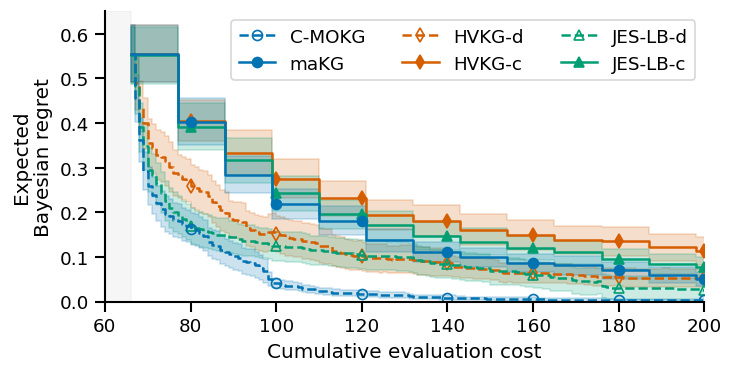

In [38]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120, constrained_layout=True)
    plot_mean_metrics_comparison(stats["lengthscales"], "scalarperf_regret", algorithms=MAIN_ALGOS, ax=ax)
    ax.set_xlim(left=60, right=200)

if SAVE_PLOTS:
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-scalarperf.png"), dpi=200)
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-scalarperf.pdf"))

#### Hypervolume regret
This appears as Figure 2a in the paper.

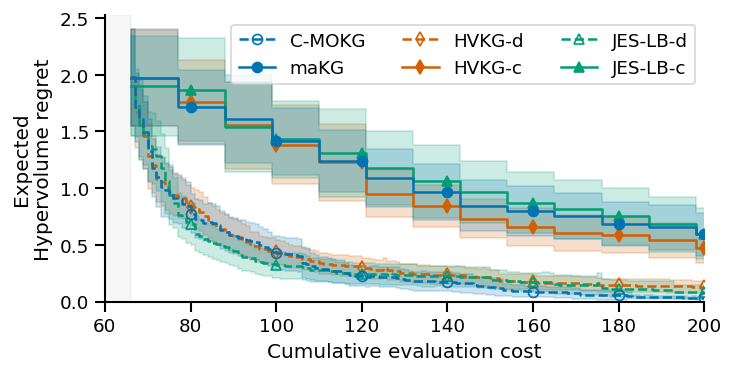

In [39]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120, constrained_layout=True)
    plot_mean_metrics_comparison(stats["lengthscales"], "hv_regret", algorithms=MAIN_ALGOS, ax=ax)
    # ax.set_xlim(left=50, right=300)
    ax.set_xlim(left=60, right=200)

if SAVE_PLOTS:
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-hypervol.png"), dpi=200)
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-hypervol.pdf"))

### Problem family: objectives with and without observation noise
#### Expected Bayesian regret
This appears as Figure 1b in the paper.

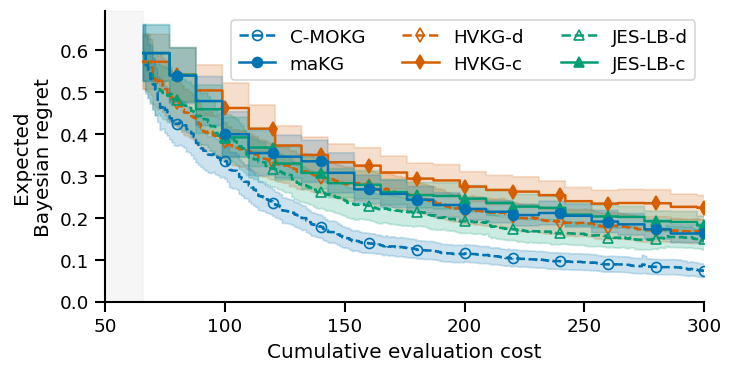

In [40]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120, constrained_layout=True)
    plot_mean_metrics_comparison(stats["observationnoise"], "scalarperf_regret", algorithms=MAIN_ALGOS, ax=ax)
    ax.set_xlim(left=50, right=300)

if SAVE_PLOTS:
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-observationnoise-scalarperf.png"), dpi=200)
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-observationnoise-scalarperf.pdf"))

#### Hypervolume regret
This appears as Figure 2b in the paper.

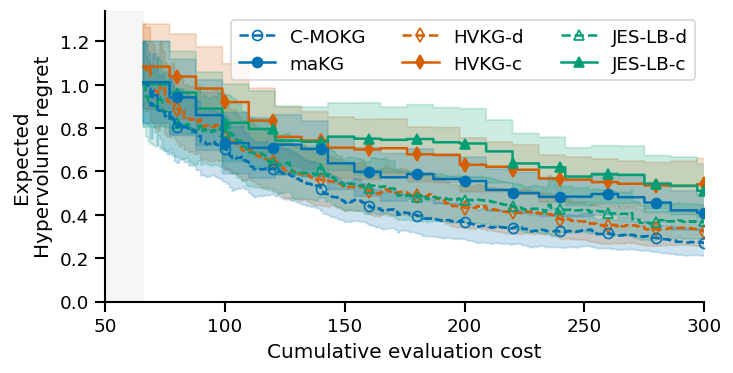

In [41]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120, constrained_layout=True)
    plot_mean_metrics_comparison(stats["observationnoise"], "hv_regret", algorithms=MAIN_ALGOS, ax=ax)
    ax.set_xlim(left=50, right=300)

if SAVE_PLOTS:
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-observationnoise-hypervol.png"), dpi=200)
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-observationnoise-hypervol.pdf"))

### Comparison between expectation and random scalarisations (for problem family where objectives have different length scales)
These plots show how taking expectation over scalarisations gives a big performance increase in the case of decoupled evaluations. It can be seen that this is not the case when evaluations are coupled.

#### Expected Bayesian regret
This appears as Figure 4 in the paper.

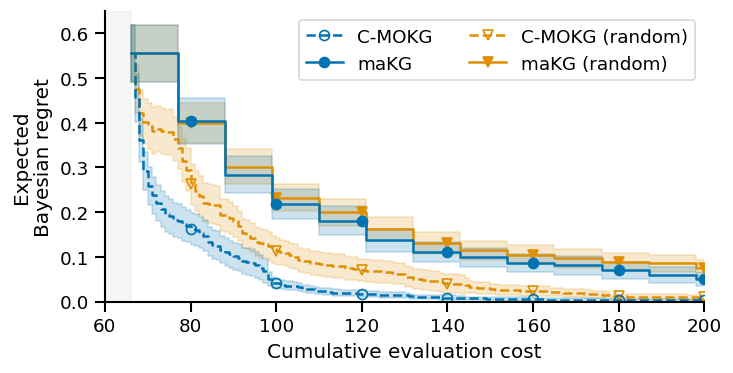

In [42]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120, constrained_layout=True)

    plot_mean_metrics_comparison(
        stats["lengthscales"],
        "scalarperf_regret",
        algorithms=[
            ("kg-discrete", "decoupled"),
            ("kg-discrete", "fulleval"),
            ("kg-discrete-random", "decoupled"),
            ("kg-discrete-random", "fulleval"),
        ],
        ax=ax,
        legend_cols=2,
    )
    ax.set_xlim(left=60, right=200)

if SAVE_PLOTS:
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-scalarperf-expvsrandom.png"), dpi=200)
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-scalarperf-expvsrandom.pdf"))

#### Hypervolume regret

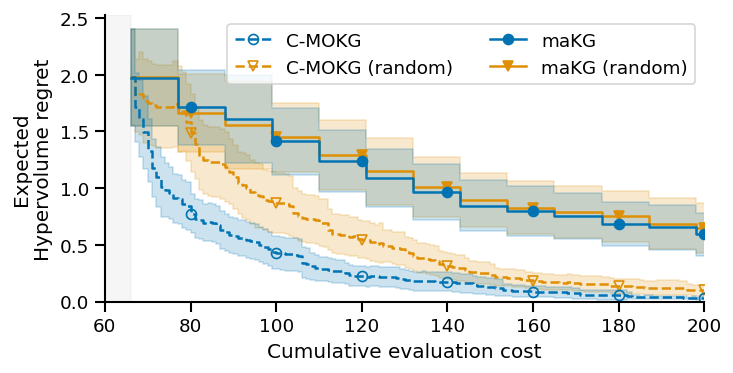

In [43]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120, constrained_layout=True)

    plot_mean_metrics_comparison(
        stats["lengthscales"],
        "hv_regret",
        algorithms=[
            ("kg-discrete", "decoupled"),
            ("kg-discrete-random", "decoupled"),
            ("kg-discrete", "fulleval"),
            ("kg-discrete-random", "fulleval"),
        ],
        ax=ax,
        legend_cols=2,
    )
    ax.set_xlim(left=60, right=200)

if SAVE_PLOTS:
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-hypervol-expvsrandom.png"), dpi=200)
    fig.savefig(os.path.join(PLOTS_DIR, "metrics-lengthscales-hypervol-expvsrandom.pdf"))

## Example of convergence of the predicted Pareto front
Here we generate the plots showing convergence to the Pareto from from Figure 3 in the paper.

In [44]:
true_pareto, posterior_pareto, test_problem = data_loader.load_test_problem("lengthscales", "kg-discrete", "eval_separate", run="1", num_iterations=93)

  0%|          | 0/3 [00:00<?, ?it/s]

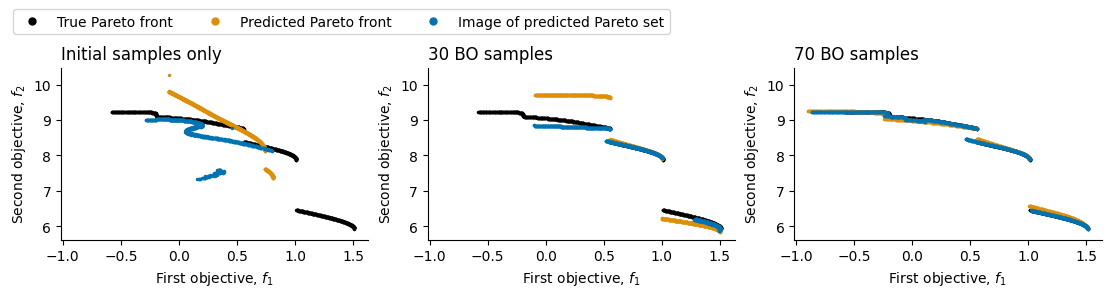

In [45]:
fig = plot_pareto_fronts_for_several_iterations(
    true_pareto,
    posterior_pareto,
    test_problem["problem"],
    iterations=[0, 30, 70],  # For this problem, 70 samples is approximately 200 cost
)

if SAVE_PLOTS:
    fig.savefig(os.path.join(PLOTS_DIR, "pareto-fronts-lengthscales-run1.png"), dpi=200, bbox_inches="tight")
    fig.savefig(os.path.join(PLOTS_DIR, "pareto-fronts-lengthscales-run1.pdf"), bbox_inches="tight")

And a version where we plot them separately so we can use subcaption in the paper.

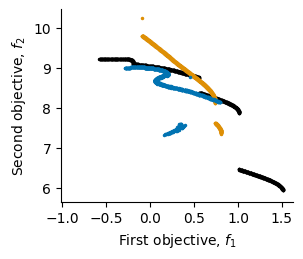

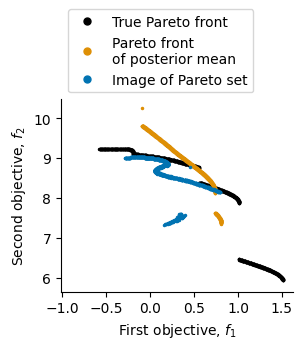

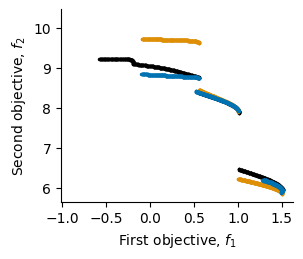

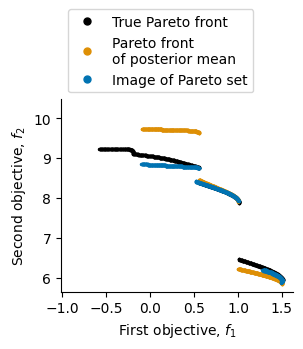

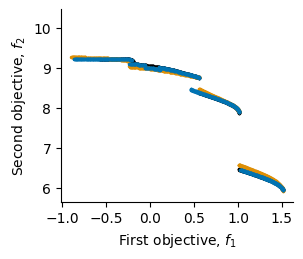

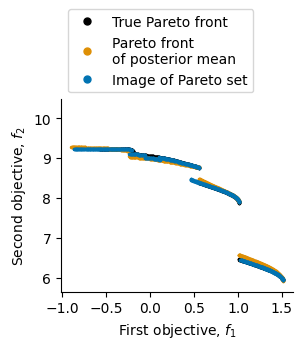

In [46]:
# For this problem, 70 samples is approximately 200 cost
axs = {"legend": [], "nolegend": []}
iterations = [0, 30, 70]
for it in iterations:
    for k, leg in [("nolegend", False), ("legend", True)]:
        ax = plot_pareto_front(
            true_pareto,
            posterior_pareto[it],
            test_problem["problem"],
            legend=leg,
        )
        axs[k].append(ax)

xlim = (
    min(ax.get_xlim()[0] for k in axs for ax in axs[k]),
    max(ax.get_xlim()[1] for k in axs for ax in axs[k])
)
ylim = (
    min(ax.get_ylim()[0] for k in axs for ax in axs[k]),
    max(ax.get_ylim()[1] for k in axs for ax in axs[k])
)

for k in axs:
    for ax in axs[k]:
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))

if SAVE_PLOTS:
    for leg_k in axs:
        for it, ax in zip(iterations, axs[leg_k]):
            for ext in ["png", "pdf"]:
                ax.figure.savefig(
                    os.path.join(
                        PLOTS_DIR,
                        f"pareto-fronts-lengthscales-run1-decoupled-{it}-{leg_k}.{ext}"),
                    bbox_inches="tight",
                    dpi=200,
                )

## Times to optimise the acquisition function

In [47]:
all_timings = {
    k1: {
        k2: data_loader.load_timings(k1, v2)
        for k2, v2 in {
            "decoupled": "eval_separate",
            "fulleval": "eval_full",
        }.items()
    }
    for k1 in  tqdm(DATA_DIRS, desc="Loading data")
}

Loading data:   0%|          | 0/7 [00:00<?, ?it/s]

Loading ('lengthscales', 'kg-discrete') | eval_separate:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('lengthscales', 'kg-discrete') | eval_full:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('lengthscales', 'kg-discrete-random') | eval_separate:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('lengthscales', 'kg-discrete-random') | eval_full:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('lengthscales', 'jes') | eval_separate:   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 17
Could not load run 49
Could not load run 51
Could not load run 54
Could not load run 72
Could not load run 75
Failed to load 6 out of 100 runs in total


Loading ('lengthscales', 'jes') | eval_full:   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 17
Could not load run 49
Could not load run 51
Could not load run 54
Could not load run 72
Could not load run 75
Failed to load 6 out of 100 runs in total


Loading ('lengthscales', 'hvkg') | eval_separate:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('lengthscales', 'hvkg') | eval_full:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('observationnoise', 'kg-discrete') | eval_separate:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('observationnoise', 'kg-discrete') | eval_full:   0%|          | 0/100 [00:00<?, ?it/s]

Loading ('observationnoise', 'jes') | eval_separate:   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 2
Could not load run 17
Could not load run 35
Could not load run 40
Failed to load 4 out of 100 runs in total


Loading ('observationnoise', 'jes') | eval_full:   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 2
Could not load run 17
Could not load run 35
Could not load run 40
Could not load run 84
Failed to load 5 out of 100 runs in total


Loading ('observationnoise', 'hvkg') | eval_separate:   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 5
Could not load run 7
Could not load run 11
Could not load run 38
Could not load run 77
Could not load run 96
Failed to load 6 out of 100 runs in total


Loading ('observationnoise', 'hvkg') | eval_full:   0%|          | 0/100 [00:00<?, ?it/s]

Could not load run 5
Could not load run 7
Could not load run 11
Could not load run 38
Could not load run 39
Could not load run 77
Could not load run 96
Failed to load 7 out of 100 runs in total


In [48]:
timing_stats = {
    problem_key: pd.concat(
        {
            (alg, eval_mode): calculate_timing_stats(timings_df)
            for k, alg in all_timings
            if k == problem_key
            for eval_mode, timings_df in all_timings[problem_key, alg].items()
        },
        axis="index",
        names=["algorithm", "eval_mode"],
    )
    for problem_key in sorted({k for k, alg in all_timings})
}

### Problem family: objectives with different length scales

/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


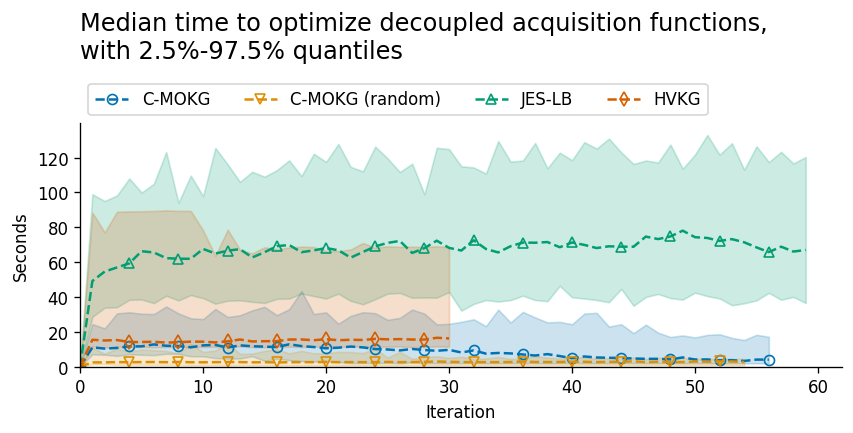

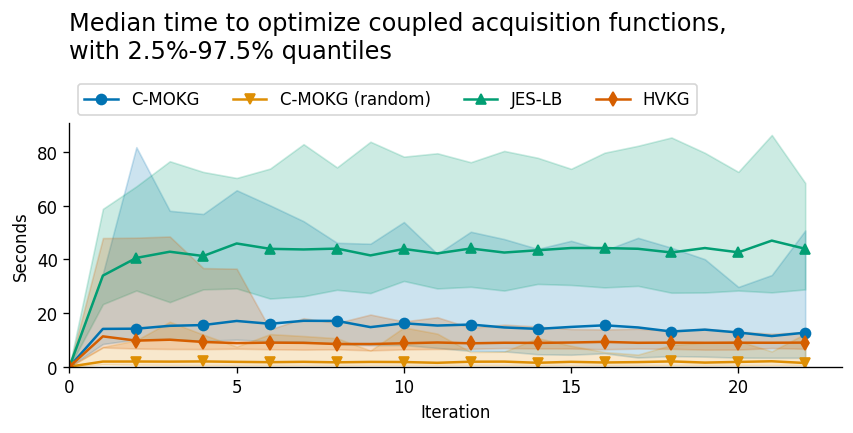

In [49]:
ax = plot_acqf_optim_timing_medians(timing_stats["lengthscales"], eval_mode="decoupled", markevery=4)

if SAVE_PLOTS:
    ax.figure.savefig(os.path.join(PLOTS_DIR, "timings-lengthscales-decoupledonly.png"), dpi=400)


ax = plot_acqf_optim_timing_medians(timing_stats["lengthscales"], eval_mode="fulleval", markevery=2)

if SAVE_PLOTS:
    ax.figure.savefig(os.path.join(PLOTS_DIR, "timings-lengthscales-coupledonly.png"), dpi=400)

### Problem family: objectives with and without observation noise

/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


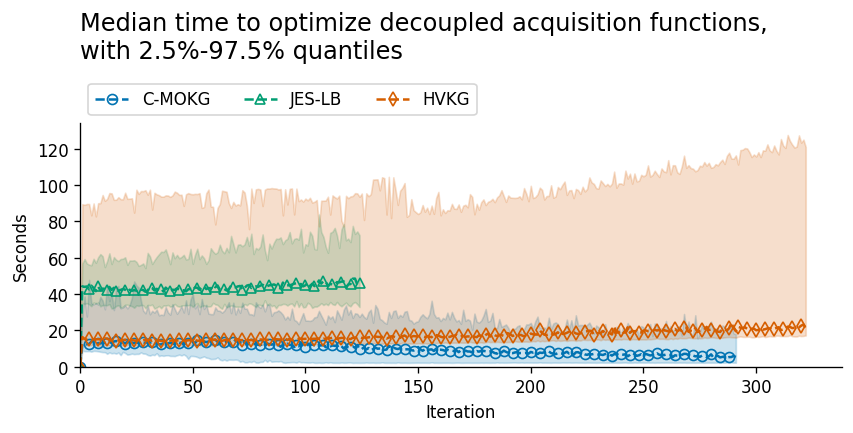

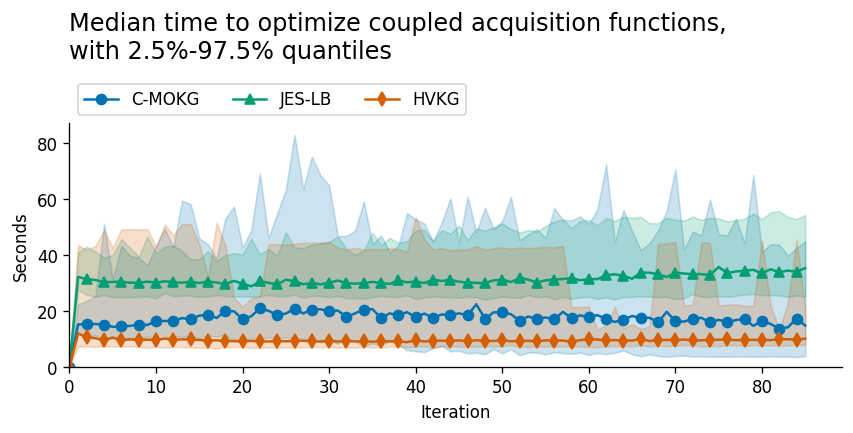

In [50]:
ax = plot_acqf_optim_timing_medians(timing_stats["observationnoise"], eval_mode="decoupled", markevery=4)

if SAVE_PLOTS:
    ax.figure.savefig(os.path.join(PLOTS_DIR, "timings-observationnoise-decoupledonly.png"), dpi=400)


ax = plot_acqf_optim_timing_medians(timing_stats["observationnoise"], eval_mode="fulleval", markevery=2)

if SAVE_PLOTS:
    ax.figure.savefig(os.path.join(PLOTS_DIR, "timings-observationnoise-coupledonly.png"), dpi=400)